In [50]:
import momepy
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point, box
from shapely.ops import unary_union
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas as dgd
import dask.distributed
import deltalake
import shapely.geometry
import mercantile
import rasterio
from rasterio.windows import from_bounds
from pyproj import transform
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import shape, Polygon, mapping, box, LineString
import fiona
from rasterio.features import shapes
import osmnx as ox
import os
from tqdm import tqdm

In [51]:
local_crs = 27700
place = "glasgow"
latlng = (-4.251846930489373, 55.86421405612109)
country = "united kingdom"
crs=4326

In [52]:
radius = 35 #km

In [53]:
## create directory ./out/{place} if it does not exist
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        
create_dir(f"./output/{place}")

## part 1: Find limits of cells to download

In [54]:
def create_square(center_point, distance):
    """
    Create a square polygon centered on the given point.
    The 'distance' parameter is half the side length of the square.
    """
    x, y = center_point.x, center_point.y
    return Polygon([(x - distance, y - distance),
                    (x - distance, y + distance),
                    (x + distance, y + distance),
                    (x + distance, y - distance)])

# Create a GeoSeries with the specified point
gdf = gpd.GeoSeries([Point(latlng[0], latlng[1])], crs=crs)

# Reproject to a coordinate system that uses meters (UTM)
gdf_utm = gdf.to_crs(epsg=local_crs)

# Get the center point in UTM coordinates
center_point = gdf_utm[0]

# Create a square polygon centered on the point
# The distance parameter is half the side length of the square.
# For a 50 km square, the distance will be 25 km.
square = create_square(center_point, radius*1000) 

# Create a GeoSeries for the square in UTM coordinates
square_gs_utm = gpd.GeoSeries([square], crs=gdf_utm.crs)

# Reproject the square back to the original CRS
area_of_interest = square_gs_utm.to_crs(epsg=crs)

# Plotting
area_of_interest.explore()

/home/virgilxw/miniconda3/envs/morph_model_v1/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


In [55]:
# # Create a GeoDataFrame with the specified point
# gdf = gpd.GeoDataFrame(geometry=[Point(latlng[0], latlng[1])], crs=crs)

# # Reproject to a coordinate system that uses meters (UTM)
# gdf_utm = gdf.to_crs(epsg=local_crs)

# # Create a 50 km buffer around the point
# buffer = gdf_utm.buffer(10000)  # 50 km buffer

# # Reproject buffer back to original CRS
# area_of_interest = buffer.to_crs(epsg=crs)

# # Plottin
# area_of_interest.explore()



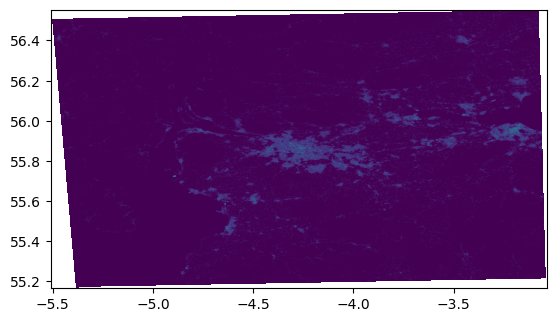

In [56]:
# Read only the portion of the GeoTIFF that intersects with the AOI

cell_polygons = []
with rasterio.open("output/built_height.tif") as src:
    # Calculate the window to read based on AOI bounds
    out_image, transformed = rasterio.mask.mask(src, area_of_interest, crop=True, filled=True)
    out_profile = src.profile.copy()
    
out_profile.update({'width': out_image.shape[2],'height': out_image.shape[1], 'transform': transformed})
with rasterio.open(f"output/{place}.tif", 'w', **out_profile) as dst:
    dst.write(out_image)
    
with rasterio.open(f"output/{place}.tif") as src:
    show(src)

In [57]:
def get_cell_polygon(x, y, transform):
    """
    Create a polygon for the given cell coordinates (x, y) using the affine transform.
    """
    tl = transform * (x, y)
    tr = transform * (x + 1, y)
    br = transform * (x + 1, y + 1)
    bl = transform * (x, y + 1)
    return Polygon([tl, tr, br, bl, tl])

In [58]:
mask = None
with rasterio.Env():
    with rasterio.open(f"output/{place}.tif") as src:
        image = src.read(1) # first band
        transform = src.transform

        # Prepare schema for shapefile
        schema = {
            'properties': [('raster_val', 'int')],
            'geometry': 'Polygon'
        }

        # with fiona.open(f"output/{place}/height_cells.shp", 'w', 
        #                 driver='ESRI Shapefile',
        #                 crs=src.crs,
        #                 schema=schema) as dst:
            
        #     # Iterate over each pixel in the raster
        #     for row in tqdm(range(image.shape[0])):
        #         for col in range(image.shape[1]):
        #             value = image[row, col]
        #             polygon = get_cell_polygon(col, row, transform)
        #             dst.write({
        #                 'properties': {'raster_val': int(value)},
        #                 'geometry': mapping(polygon)
        #             })
        
        # List to hold each feature
        features = []

        # Iterate over each pixel in the raster
        for row in tqdm(range(image.shape[0])):
            for col in range(image.shape[1]):
                value = image[row, col]
                polygon = get_cell_polygon(col, row, transform)
                features.append({
                    'properties': {'raster_val': int(value)},
                    'geometry': polygon
                })

        # Create a GeoDataFrame
        area_of_interest = gpd.GeoDataFrame([f['properties'] for f in features],
                            geometry=[f['geometry'] for f in features],
                            crs=src.crs)
        
        area_of_interest.to_parquet(f"output/{place}/height_cells.shp")


100%|██████████| 1396/1396 [01:35<00:00, 14.59it/s]


# part 2: create a buffer that is slightly larger to account for edge effects and download all building footprints + street data

In [59]:
# Get bounds
minx, miny, maxx, maxy = area_of_interest.total_bounds
min_dist = min([abs(minx-latlng[0]), abs(miny-latlng[1]), abs(maxx-latlng[0]), abs(maxy-latlng[1])])

# Create a GeoDataFrame with the specified point
gdf = gpd.GeoDataFrame(geometry=[Point(latlng[0], latlng[1])], crs=crs)

# Reproject to a coordinate system that uses meters (UTM)
gdf_utm = gdf.to_crs(epsg=local_crs)

# Create a 50 km buffer around the point
buffer = gdf_utm.buffer((radius+5)*1000)  # 30 km buffer

# Reproject buffer back to original CRS
buffer = buffer.to_crs(epsg=crs)

# Plottin
buffer.explore()



/home/virgilxw/miniconda3/envs/morph_model_v1/lib/python3.11/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


In [60]:
# # This creates a boolean mask where each element is True if the geometry in `gdf` is within any geometry in `area_of_interest`
# mask = area_of_interest.geometry.apply(lambda geom: any(geom.within(aoi_geom) for aoi_geom in buffer.geometry))

# # Apply the mask to select only the relevant features
# selected_features = area_of_interest[mask]

In [61]:
# selected_features_union = selected_features.unary_union

# selected_features_union = gpd.GeoSeries([selected_features_union]).set_crs(epsg=4326)

In [62]:
# selected_features_union.plot()

In [63]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("ms-buildings")

asset = collection.assets["delta"]

storage_options = {
    "account_name": asset.extra_fields["table:storage_options"]["account_name"],
    "sas_token": asset.extra_fields["table:storage_options"]["credential"],
}
table = deltalake.DeltaTable(asset.href, storage_options=storage_options)

quadkeys = [
    int(mercantile.quadkey(tile))
    for tile in mercantile.tiles(*buffer[0].bounds, zooms=9)
]
quadkeys

uris = table.file_uris([("quadkey", "in", quadkeys)])
uris

df = dgd.read_parquet(uris, storage_options=storage_options)


In [64]:
buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()

/tmp/ipykernel_28438/1505170059.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  buildings = dgd.sjoin(df, gpd.GeoDataFrame(geometry=buffer), how="inner", op="intersects").compute()


In [65]:
world_poly = gpd.read_file("input/glasgow_study_area.shp")

In [66]:
water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})
water_gdf = water_gdf[water_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]

/tmp/ipykernel_28438/2221155826.py:1: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  water_gdf = ox.geometries_from_polygon(buffer[0], tags={"natural": "water"})


In [67]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in water_gdf.columns if col != 'geometry']

# Drop these columns
water_gdf = water_gdf.drop(columns=columns_to_drop)

In [68]:
buffer = gpd.GeoDataFrame(geometry=buffer)

In [70]:
buffer = world_poly.overlay(buffer, how='intersection').overlay(water_gdf, how='difference')

<Axes: >

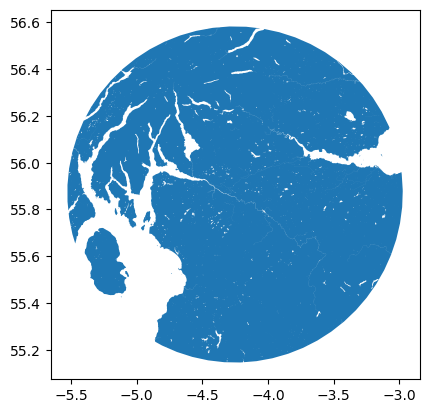

In [71]:
buffer.plot()

In [72]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in buffer.columns if col != 'geometry']

# Drop these columns
buffer = buffer.drop(columns=columns_to_drop)

In [ ]:
buffer_new = buffer.dissolve()

In [82]:
buffer_new.to_parquet(f"./output/{place}/study_area.pq")

In [79]:
buffer_new = buffer.dissolve()

In [81]:
osm_graph= ox.graph.graph_from_polygon(buffer_new.geometry[0], network_type='drive')
osm_graph = ox.projection.project_graph(osm_graph, to_crs=local_crs)
streets = ox.graph_to_gdfs(
    ox.get_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
    
)

streets.head()

osmid  \
u      v         key                                                      
352357 352019    0                [4000338, 22927507, 4000330, 4000326]   
       352428    0    [45558818, 4000343, 45558604, 22927511, 229275...   
       375777923 0                                             19248400   
352019 352010    0    [4000326, 194344455, 194344457, 194344460, 194...   
       9810130   0                                              4000327   

                      oneway lanes     ref        highway maxspeed reversed  \
u      v         key                                                          
352357 352019    0      True     3  A74(M)       motorway   70 mph    False   
       352428    0      True     3  A74(M)       motorway   70 mph    False   
       375777923 0      True     1     NaN  motorway_link   70 mph    False   
352019 352010    0      True     3  A74(M)       motorway   70 mph    False   
       9810130   0      True     1  A74(M)  motorway_link   70 mph    False   

                         length  \
u      v         key              
352357 352019    0    20055.604   
       352428    0     4493.577   
       375777923 0      361.675   
352019 352010    0     1225.326   
       9810130   0      635.724   

                                                               geometry  \
u      v         key                                                      
352357 352019    0    LINESTRING (295636.156 617612.965, 295661.479 ...   
       352428    0    LINESTRING (294093.897 620498.427, 294210.905 ...   
       375777923 0    LINESTRING (295645.723 617945.181, 295639.862 ...   
352019 352010    0    LINESTRING (307333.313 603480.022, 307401.637 ...   
       9810130   0    LINESTRING (307333.313 603480.022, 307474.735 ...   

                           from       to bridge junction name access width  \
u      v         key                                                         
352357 352019    0       352357   352019    NaN      NaN  NaN    NaN   NaN   
       352428    0       352428   352357    yes      NaN  NaN    NaN   NaN   
       375777923 0    375777923   352357    NaN      NaN  NaN    NaN   NaN   
352019 352010    0       352019   352010    yes      NaN  NaN    NaN   NaN   
       9810130   0       352019  9810130    NaN      NaN  NaN    NaN   NaN   

                     tunnel est_width service  
u      v         key                           
352357 352019    0      NaN       NaN     NaN  
       352428    0      NaN       NaN     NaN  
       375777923 0      NaN       NaN     NaN  
352019 352010    0      NaN       NaN     NaN  
       9810130   0      NaN       NaN     NaN

In [83]:
# List all columns to drop, which is all except 'geometry'
columns_to_drop = [col for col in streets.columns if col != 'geometry']

# Drop these columns
streets = streets.drop(columns=columns_to_drop)

In [84]:
# Assuming your GeoDataFrame is named 'gdf'
line_strings = []
for geometry in streets.geometry:
    if geometry.geom_type == 'LineString':
        line_strings.append(geometry)
    elif geometry.geom_type == 'MultiLineString':
        line_strings.extend(list(geometry))

In [85]:
collection = shapely.GeometryCollection(line_strings)  # combine to a single object
noded = shapely.node(collection)  # add missing nodes
streets_noded_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(noded), crs=local_crs)

<Axes: >

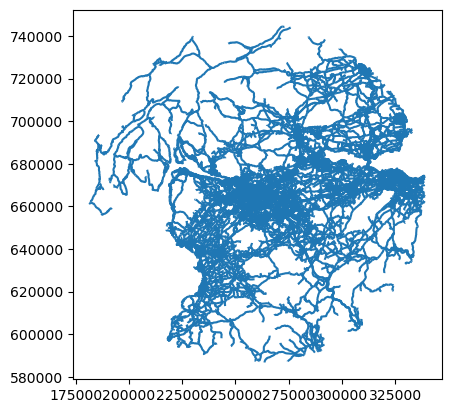

In [86]:
streets_noded_gdf.plot()

In [87]:
buildings.to_parquet(f"./output/{place}/buildings_raw.pq")

streets_noded_gdf.to_parquet(f"./output/{place}/streets_raw.pq")

<Axes: >

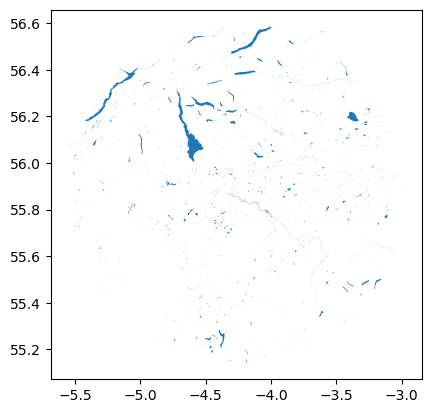

In [88]:
water_gdf.plot()

In [89]:
water_gdf.to_parquet(f"./output/{place}/water.pq")

: 